In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns 


In [5]:
data = pd.read_csv(r'C:\Users\wipip\OneDrive\Documentos\GitHub\Time-Series-0-main\data\processed\data_procesada.csv')

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [6]:
data['date'] = pd.to_datetime(data['date'])

Verificamos que nuestros datos muestran una serie temporal estacionaria con la prueba de dickey-fuller 

In [7]:
def prueba_estacionalidad(serie):
    resultado = adfuller(serie.dropna())
    print(f'Estadistica del test: {resultado[0]}')
    print(f'p-value:{resultado[1]}')
    for key, value in resultado[4].items():
        print(f'Valor critico ({key}): {value}')

prueba_estacionalidad(data['sales'])

Estadistica del test: -4.405477795888465
p-value:0.00029027637607763747
Valor critico (1%): -3.449226932880019
Valor critico (5%): -2.869857365438656
Valor critico (10%): -2.571201085130664


Podemos ver que con la transformacion logaritmica que hicimos fue suficiente para transformar nuestra serie en estacionaria, con el p - value de .00029 que nos permite rechazar la hipotesis nula en la prueba de dickey fuller, adicionalmente vemos que la estadistica del test es menor a todos los vaores criticos lo que refuerza la conclusion de una serie temporal estacionaria por lo que vamos a continuar

Haremos nuestros graficos de correlacion y correlacion parcial

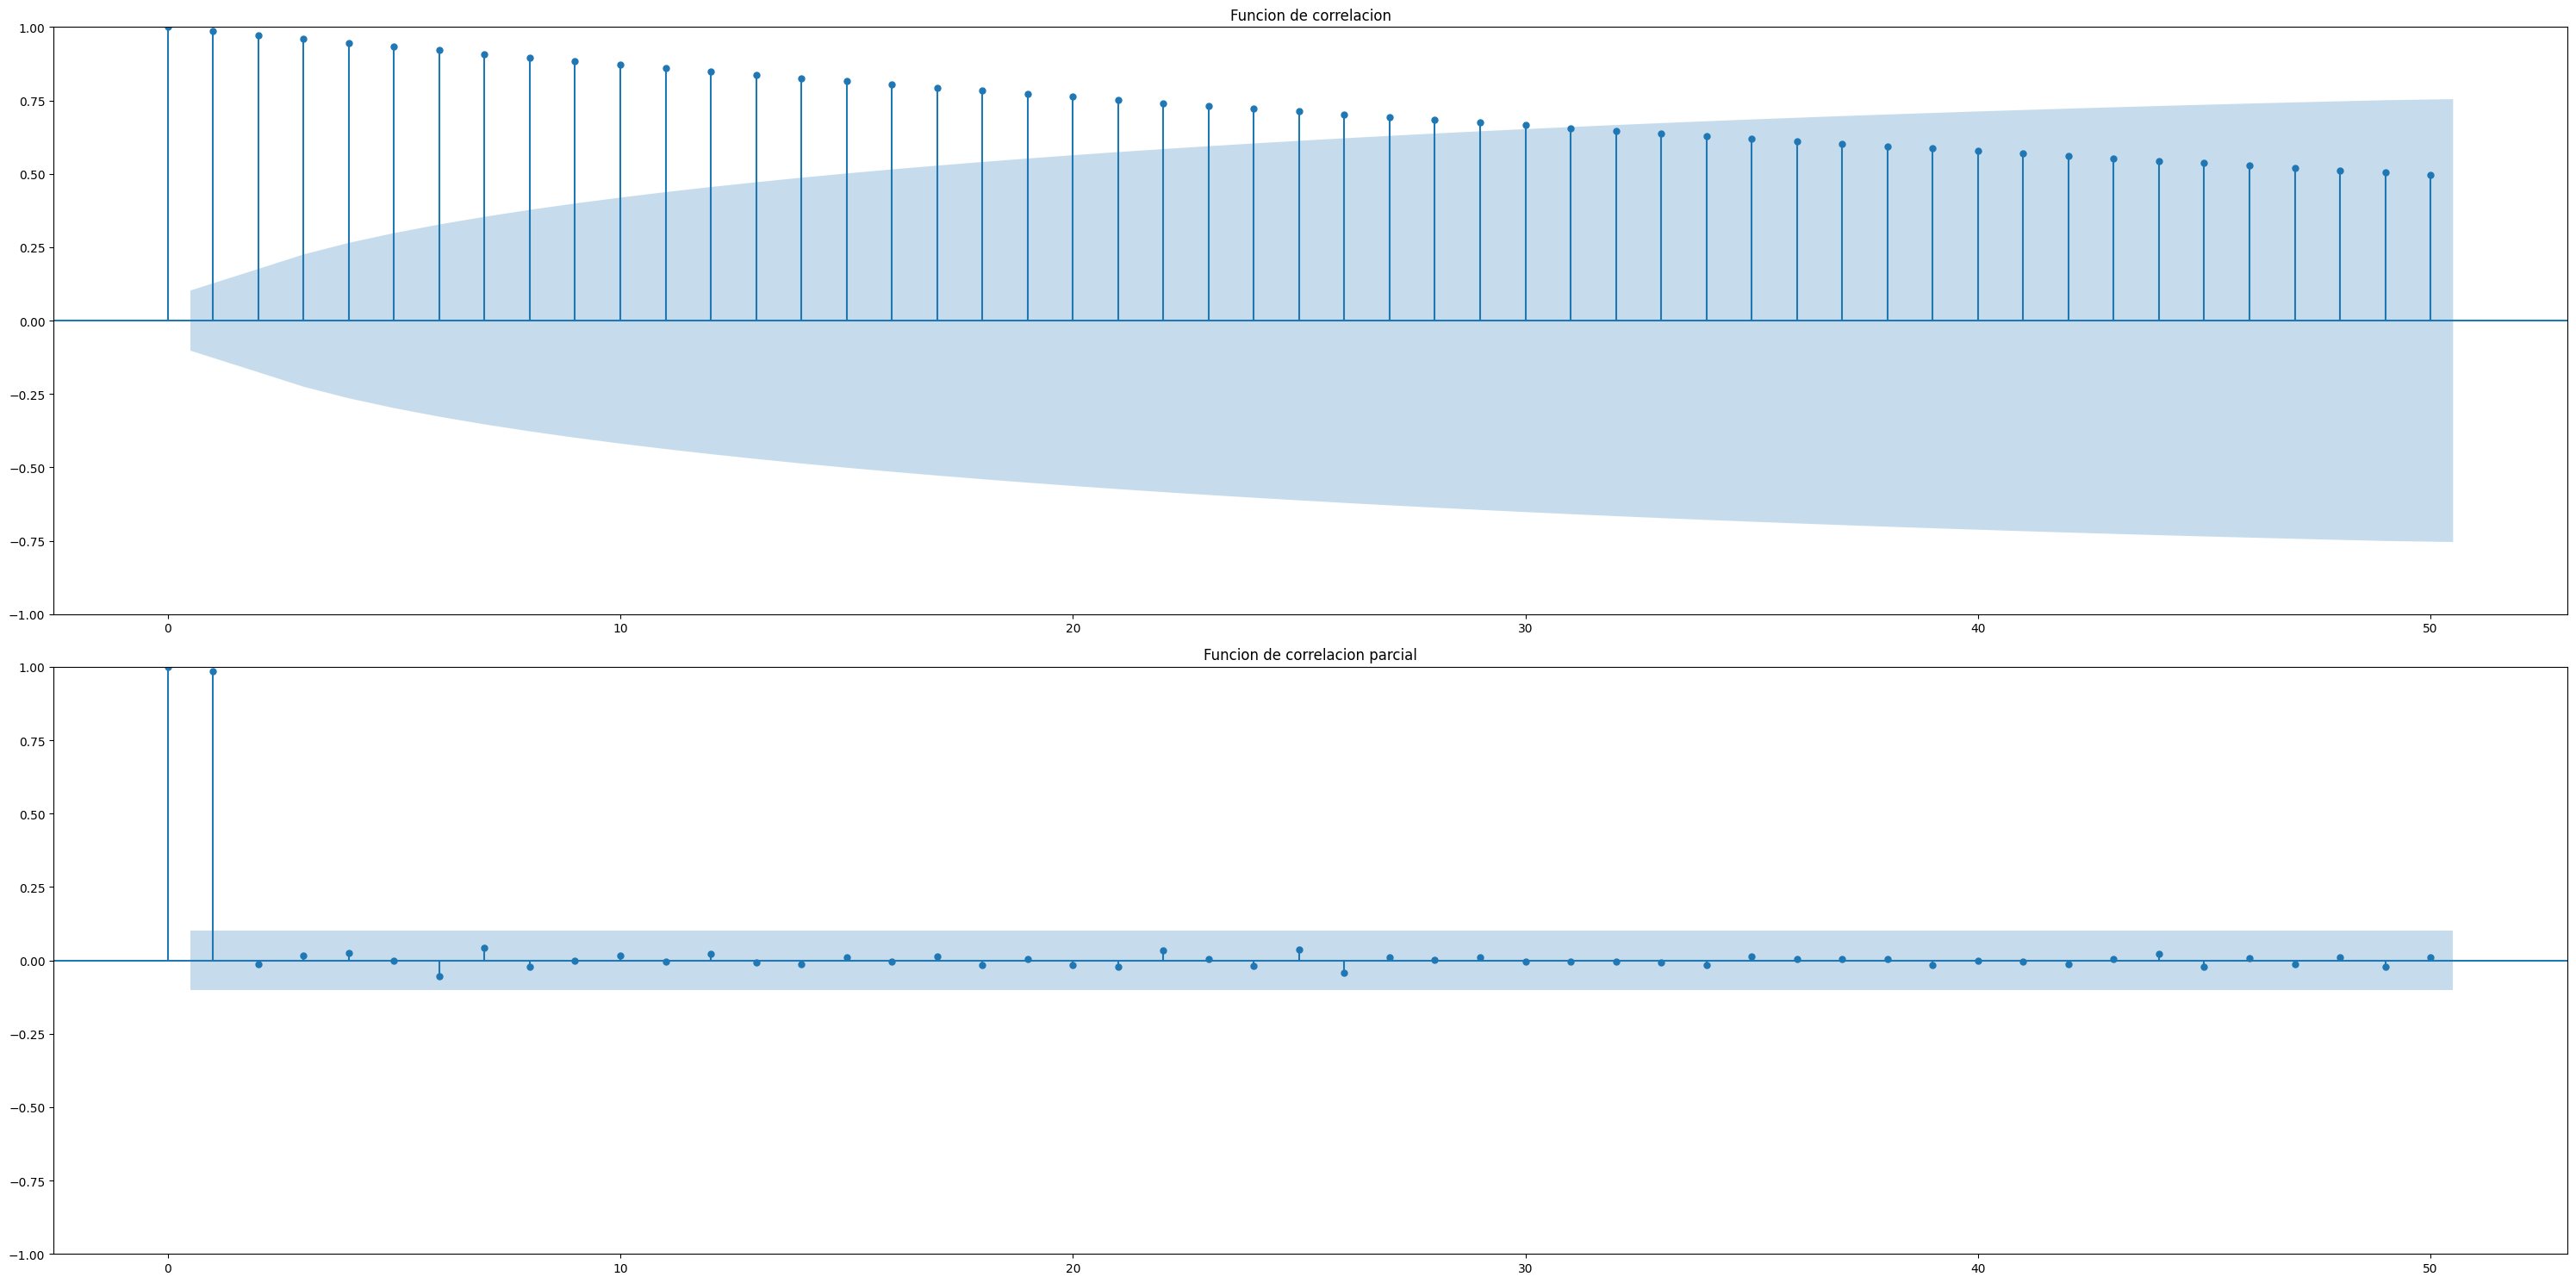

In [8]:

plt.figure(figsize=(30, 15))

plt.subplot(2, 1, 1)
plot_acf(data['sales'].dropna(), ax=plt.gca(), lags=50)
plt.title('Funcion de correlacion')
plt.subplot(2, 1, 2)
plot_pacf(data['sales'].dropna(), ax=plt.gca(), lags=50)
plt.title('Funcion de correlacion parcial')

plt.tight_layout()
plt.show()


En el grafico de autocorrelacion podemos ver una alta correlacion al inicio junto con una tendencia a la disminucion poco a poco, esto se interpreta como que tenemos terminos autoregresivos dominantes, por lo que el comportamiento de la serie temporal indica que el valor de la serie temporal en un momento dado es dado por una funcion lineal de sus valores pasados junto con un termino de error, Aunado a esto tendremos dos picos significantes y despues una diminucion practicamente a cero en el grafico de autocorrelacion parcial lo que tambien indica una fuerte presencia de los terminos autoregresivos.

Por ello es que los parametros inciales para nuestro modelo ARIMA seran de:

p = 2 #En 2 es la caida de los picos significantes

q = 0 #Tenemos una disminucion lenta y constante

d = 0 (debido a que ya transformamos la serie para llegar a la estacionalidad)

Continuamos generando el modelo ARIMA creando una funcion para ajustar y evaluar el modelo, una para la prediccion y grafico y otra para hacer el calculo de metricas

In [9]:
import warnings
warnings.filterwarnings('ignore', message='ConvergenceWarning')

In [10]:
def analisis_arima(data, p,d,q):
    
    modelo = ARIMA(data, order=(p,d,q))
    ajuste_modelo = modelo.fit(method_kwargs={'maxiter': 20000, 'disp':0})
    
    predicciones = ajuste_modelo.predict(start=data.index[0], end=data.index[-1])
    mae = mean_absolute_error(data.dropna(), predicciones)
    rmse = np.sqrt(mean_squared_error(data.dropna(), predicciones))
    
    return print(f'Reporte de Modelo \n {ajuste_modelo.summary()}\n Metricas de modelo: \n MAE:{mae} \n RMSE: {rmse}')

In [11]:
analisis_arima(data['sales'], 3,0,1)

Reporte de Modelo 
                                SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  366
Model:                 ARIMA(3, 0, 1)   Log Likelihood                 884.997
Date:                Sat, 14 Sep 2024   AIC                          -1757.994
Time:                        23:39:47   BIC                          -1734.579
Sample:                             0   HQIC                         -1748.690
                                - 366                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4727     28.576      0.157      0.876     -51.534      60.480
ar.L1         -0.0948      0.061     -1.559      0.119      -0.214       0.024
ar.L2          0.9851      0.055

In [12]:
for p in range (1,4):
    for q in range (0,3):
        for d in range (0, 3):
            analisis_arima(data['sales'], p, d, q)

Reporte de Modelo 
                                SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  366
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 882.972
Date:                Sat, 14 Sep 2024   AIC                          -1759.944
Time:                        23:39:47   BIC                          -1748.236
Sample:                             0   HQIC                         -1755.291
                                - 366                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4677      1.452      3.767      0.000       2.623       8.313
ar.L1          0.9999      0.002    631.179      0.000       0.997       1.003
sigma2         0.0005   1.76e-05

c:\Users\wipip\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Reporte de Modelo 
                                SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  366
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 885.039
Date:                Sat, 14 Sep 2024   AIC                          -1762.078
Time:                        23:39:49   BIC                          -1746.468
Sample:                             0   HQIC                         -1755.875
                                - 366                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4829      1.585      3.459      0.001       2.376       8.590
ar.L1          0.8937      0.025     35.199      0.000       0.844       0.943
ar.L2          0.1062      0.025

c:\Users\wipip\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\wipip\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Reporte de Modelo 
                                SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  366
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 967.137
Date:                Sat, 14 Sep 2024   AIC                          -1926.274
Time:                        23:39:50   BIC                          -1910.674
Sample:                             0   HQIC                         -1920.074
                                - 366                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5237      0.022     23.275      0.000       0.480       0.568
ar.L2          0.4748      0.022     21.283      0.000       0.431       0.519
ma.L1         -0.9368      0.016

c:\Users\wipip\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Reporte de Modelo 
                                SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  366
Model:                 ARIMA(2, 2, 1)   Log Likelihood                 982.290
Date:                Sat, 14 Sep 2024   AIC                          -1956.581
Time:                        23:39:50   BIC                          -1940.992
Sample:                             0   HQIC                         -1950.385
                                - 366                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6352      0.031    -20.175      0.000      -0.697      -0.574
ar.L2         -0.3190      0.034     -9.350      0.000      -0.386      -0.252
ma.L1         -0.9123      0.015

c:\Users\wipip\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Reporte de Modelo 
                                SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  366
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 971.352
Date:                Sat, 14 Sep 2024   AIC                          -1930.703
Time:                        23:39:55   BIC                          -1907.304
Sample:                             0   HQIC                         -1921.404
                                - 366                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3027      0.086     -3.500      0.000      -0.472      -0.133
ar.L2          0.8222      0.058     14.230      0.000       0.709       0.935
ar.L3          0.4730      0.036

Hacemos un for loop que simule un grid search manual, donde veremos que los parametros que mejor se ajustan a nuestro modelo en cuestion de metricas de mae y rsme son p= 3, d=0 y q= 1.

En este punto llegamos a un punto del analisis donde se debe reconsiderar lo estipulado anteriormente, ya que debido al comportamiento del grafico de funcion de autocorrelacion se penso que el mejor valor para los terminos de media movil que usariamos era de cero debido a que no se tiene una caida notable en los valores significantes, sin embargo al probar el modelo con un valor de q=1 como el numero de terminos de media movil utilizados para modelar el error de prediccion como la combinacion lineal de los errores de prediccion pasados, de esta forma el modelo toma el error del valor pasado mas cercano y lo incluye en la siguiente prediccion.

In [13]:
analisis_arima(data['sales'], 3,0,1)

Reporte de Modelo 
                                SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  366
Model:                 ARIMA(3, 0, 1)   Log Likelihood                 884.997
Date:                Sat, 14 Sep 2024   AIC                          -1757.994
Time:                        23:39:55   BIC                          -1734.579
Sample:                             0   HQIC                         -1748.690
                                - 366                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4727     28.576      0.157      0.876     -51.534      60.480
ar.L1         -0.0948      0.061     -1.559      0.119      -0.214       0.024
ar.L2          0.9851      0.055

Como conclusion de este bloque de analisis tendremos las metricas de MAE Y RMSE, donde tenemos ambos valores cercanos a cero, lo que indica predicciones precisas, adicionalmente podemos tomar que el rmse es un poco mas del doble que el mae, lo que se le adjudica  a las variaciones diarias que vemos como ruido en la serie temporal, el rmse es 2.3 veces mas grande que el mae lo que nos indica la presencia de ciertos valores con errores que casi pueden ser considerados atipicos. Sin embargo para el modelo arima que estamos construyendo, los valores de: 

3 terminos autorregresivos 
0 diferencias (debido a que la serie ya es estacionaria)
1 terminos de media movil 

Son los mas optimos para reducir el Error medio absoluto y el error cuadratico medio.

Hasta este punto podemos afirmmar que:

La serie es estacionaria debido a que se utiizo la transformacion logaritmica y se confirmo con la prueba de dickey fuller.

Los parametros mas adecuados para el modelo arima son de p=3, d=0 y q=1.



Ahora dividimos el modelo en train y test para determinar la precision de predicciones de nuestro modelo y lo iniciamos, tomando en cuenta que debemos agregar parametros adicionales para especificar el numero de iteraciones maximo, debido a que arroja una advertencia si no lo hacemos por ello utilizamos maxitter=20000, junto con disp=0 para para suprimir que el modelo muestre informacion de progreso mientras optimizamos

In [14]:
train_size = int(len(data) * 0.8)
data_train, data_test = data['sales'][:train_size], data['sales'][train_size:]



In [15]:

mod_optimizado = ARIMA(data['sales'], order=(3,0,1))
mod_ajuste = mod_optimizado.fit(method_kwargs={'maxiter': 20000, 'disp':0})

Ahora hacemos nuestras predicciones de testing y despues transformamos a la magnitud original utilizando la funcion exponencial 

In [16]:
predicciones_test_logaritmicas = mod_ajuste.forecast(steps=len(data_test))
predicciones_escala_original = np.exp(predicciones_test_logaritmicas)

Calculamos error medio absoluto y error cuadratico medio para el conjunto de testing

In [17]:
mae = mean_absolute_error(np.exp(data_test), predicciones_escala_original)
rmse = np.sqrt(mean_squared_error(np.exp(data_test), predicciones_escala_original))

print(f'MAE del conjunto de validación: {mae}')
print(f'RMSE del conjunto de validación: {rmse}')


MAE del conjunto de validación: 91.4568161122604
RMSE del conjunto de validación: 107.88917338242851


In [18]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(np.exp(data_test), predicciones_escala_original)
precision = 100 - mape

print(f'MAPE del conjunto de validación: {mape:.2f}%')
print(f'Precisión del conjunto de validación: {precision:.2f}%')

MAPE del conjunto de validación: 10.54%
Precisión del conjunto de validación: 89.46%


In [19]:
mae = mean_absolute_error(np.exp(data_test), predicciones_escala_original)
rmse = np.sqrt(mean_squared_error(np.exp(data_test), predicciones_escala_original))

print(f'MAE del conjunto de validación: {mae}')
print(f'RMSE del conjunto de validación: {rmse}')


MAE del conjunto de validación: 91.4568161122604
RMSE del conjunto de validación: 107.88917338242851


In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
modelo_sarima = SARIMAX(data['sales'], order=(1, 2, 2), seasonal_order=(1, 1, 1, 12))
warnings.filterwarnings('ignore')
resultado_sarima = modelo_sarima.fit(maxiter=10000, method='powell')

print(resultado_sarima.summary())


Optimization terminated successfully.
         Current function value: -2.685351
         Iterations: 6
         Function evaluations: 470
                                      SARIMAX Results                                       
Dep. Variable:                                sales   No. Observations:                  366
Model:             SARIMAX(1, 2, 2)x(1, 1, [1], 12)   Log Likelihood                 982.839
Date:                              Sat, 14 Sep 2024   AIC                          -1953.677
Time:                                      23:44:21   BIC                          -1930.495
Sample:                                           0   HQIC                         -1944.452
                                              - 366                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

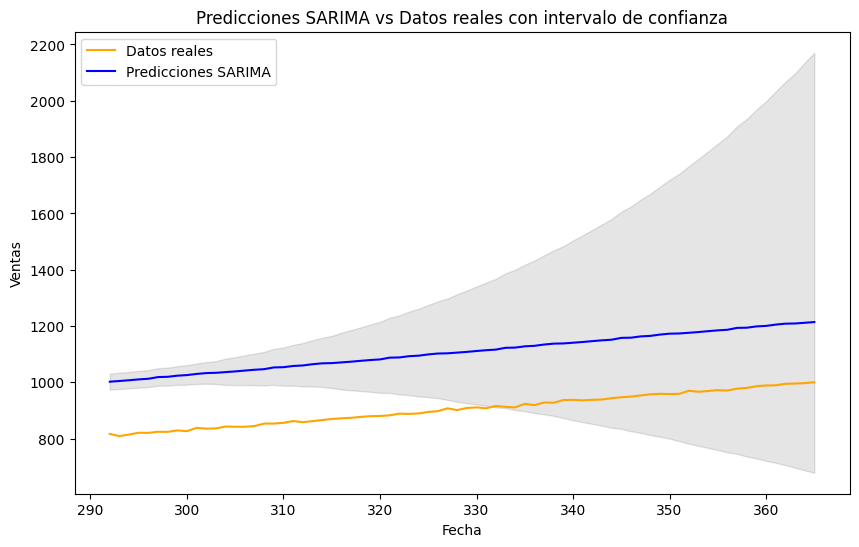

In [26]:
predicciones_sarima = resultado_sarima.get_forecast(steps=len(data_test))
predicciones_sarima_mean = predicciones_sarima.predicted_mean
conf_int_sarima = predicciones_sarima.conf_int()
predicciones_escala_original_sarima = np.exp(predicciones_sarima_mean)
plt.figure(figsize=(10, 6))
plt.plot(data_test.index, np.exp(data_test), label='Datos reales', color='orange')
plt.plot(data_test.index, predicciones_escala_original_sarima, label='Predicciones SARIMA', color='blue')

plt.fill_between(data_test.index, np.exp(conf_int_sarima.iloc[:, 0]), np.exp(conf_int_sarima.iloc[:, 1]), color='k', alpha=0.1)
plt.title('Predicciones SARIMA vs Datos reales con intervalo de confianza')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()


Como conclusiones generales del proyecto podemos decir que al realizar el modelo arima se hizo un analisis detallado utilizando las funciones de ACF y PACF, donde confirmamos mediante el uso de un grid search que los mejores parametros de ARIMA fueron (3,0,1)
Evaluamos con metricas de desempenio y se obtuvieron valores bajos de MAE Y RMSE lo qu nos habla de un buen ajuste.
Utilizando ARIMA determinamos:
- Que se captura bien la dinamica de la serie temporal con errores aceptable de MAE Y RMSE
- Las predicciones se ajustan adecuadamente a los datos reales de venta.
- Es probable que ARIMA no sea el mejor modelo debido a la naturaleza estacional de los datos de ventas, ya que nos puede dejar con patrones estacionales no capturados

Dado que se encontraron tendencias de patrones estacionales se decidio utilizar SARIMA utilizando un componente estacional con una periodicidad de 12 (mensual), junto con evaluaciones de AIC y BIC cuyos valores fueron bajos, lo que nos indica un buen rendimiento en el modelo.
- Se determino que el modelo SARIMA muestra un mejor ajuste a los datos de venta que ARIMA, capturando las dinamicas estacionales presentes en los datos. 